In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

/Users/melkor/miniforge3/envs/Melkor/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from torch_sparse  import SparseTensor
from torch_scatter import scatter_max
from torch_scatter import scatter_mean

from torch_geometric.nn    import max_pool_x, GraphConv
from torch_geometric.data  import Data,Batch
from torch_geometric.utils import grid, to_dense_batch

In [4]:
from skimage import measure
import numpy as np

def to_cc_masks(masks, threshold = 12):
    all_masks = []
    for i in range(masks.size(-1)):
        #all_labels = measure.label(masks[:,:,i])
        blobs_labels = measure.label(masks[:,:,i]>0.5, background=0)
        for cc_label in range(1,blobs_labels.max()):
            cc_mask = blobs_labels == cc_label
            if cc_mask.sum() > threshold:
                all_masks.append(cc_mask[...,None])
    all_masks = np.concatenate(all_masks, axis = -1)
    return all_masks

def weighted_softmax(x, weight):
    maxes = torch.max(x, -1, keepdim=True)[0]
    x_exp = torch.exp(x - maxes)
    x_exp_sum = (torch.sum(x_exp * weight, -1, keepdim=True) + 1e-12)
    return (x_exp / x_exp_sum) * weight

In [5]:
import numpy as np
import math
import matplotlib.pyplot as plt
num_edges = 100

def visualize_affinities(indices, affinity, im = None, num_edges = 10):
    _, B, N, K = indices.shape
    W = int(math.sqrt(N))
    indices = indices.reshape([3, B, N * K])
    rand_idx = np.random.randint(0,N * K, [num_edges])
    rand_idx = torch.tensor(rand_idx).int()
    aff = affinity.reshape(B, N * K)
    if im is None: im = torch.zeros([B,3, N])
    plt.subplot(121)
    plt.imshow(im.reshape([B,3,W,W])[0].permute(1,2,0))
    for idx in rand_idx:
        u_idx = indices[1,0,idx]
        v_idx = indices[2,0,idx]
        ux, uy = u_idx // W, u_idx % W
        vx, vy = v_idx // W, v_idx % W
        color = "green" if aff[0,idx] > 0.0 else "red"
        plt.plot([uy,vy],[ux,vx], c = color)
    plt.subplot(122)
    plt.imshow(im.reshape([B,3,W,W])[0].permute(1,2,0))

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from rinarak.utils.os import load_json
import matplotlib.pyplot as plt

def normal_img(img):
    if len(img.shape) == 4:
        if not img.shape[1] in [1,3,4]: return img.permute(0,3,1,2)
    if len(img.shape) == 3:
        if not img.shape[0] in [1,3,4]: return img.permute(2,0,1)

class PlagueWorksDataset(Dataset):
    def __init__(self,name="Plagueworks", split = "train", resolution = (128,128), dataset_dir = "datasets", motion_only = True):
        super().__init__()
        self.split = split
        self.root_dir = dataset_dir + f"/{name}"

        img_data_path = dataset_dir + f"/{name}"+ f"/{split}/img"
        self.files = os.listdir(img_data_path)

        """ add a working resolution to adapt different scenes and parameters"""
        self.transform = transforms.Resize(resolution)
        self.motion_only = motion_only
    
    def __len__(self):
        return len(self.files) // 4
    
    def __len__(self): return 7

    def __getitem__(self, idx):
        root_dir = self.root_dir
        split = self.split
        img_data_path = root_dir + f"/{self.split}/img"

        #scene_data_path = root_dir + f"/{self.split}/scene/{idx}.json"
        #scene_setup = load_json(scene_data_path)
        avatar_id = "a"

        data = {}
        img1 = torch.tensor(plt.imread(img_data_path + f"/img_{idx}_1_{avatar_id}.png"))
        img2 = torch.tensor(plt.imread(img_data_path + f"/img_{idx}_2_{avatar_id}.png"))
        albedo = torch.tensor(plt.imread(img_data_path + f"/albedo_{idx}_1_{avatar_id}.png"))
        id_map = torch.tensor(plt.imread(img_data_path + f"/id_{idx}_1_{avatar_id}.png"))
        masks = np.load(img_data_path + f"/mask_{idx}_1.npy")
        ids_seq = np.load(root_dir + f"/{self.split}/scene/ids_{idx}_1.npy")
        
        #for i,id in enumerate(ids_seq):
        #    #print( str(int(id)), scene_setup[str(int(id))]["model"], scene_setup[str(int(id))]["movable"])
        #    if self.motion_only and not scene_setup[str(int(id))]["movable"]:
        #        masks[torch.tensor(masks).int() == i] = 0


        data["img1"] = self.transform(normal_img(img1))
        data["img2"] = self.transform(normal_img(img2))
        data["albedo"] = self.transform(normal_img(albedo))
        data["masks"] =self.transform(torch.tensor(masks).unsqueeze(0)).squeeze(0)
        data["ids"] = id_map
        data["ids_sequence"] = ids_seq
        #data["scene"] = scene_setup
        return data

In [7]:
def generate_local_indices(img_size, K, padding = 'constant'):
    H, W = img_size
    indice_maps = torch.arange(H * W).reshape([1, 1, H, W]).float()

    # symetric_padding
    assert K % 2 == 1 # assert K is odd
    half_K = int((K - 1) / 2)

    assert padding in ["reflection", "constant"]
    if padding == "constant":
        pad_fn = torch.nn.ReflectionPad2d(half_K)
    else:
        pad_fn = torch.nn.ConstantPad2d(half_K)
    
    indice_maps = pad_fn(indice_maps)

    local_inds = F.unfold(indice_maps, kernel_size = K, stride = 1)

    local_inds = local_inds.permute(0,2,1)
    return local_inds

def local_to_sparse_global_affinity(local_adj, sample_inds, activated=None, sparse_transpose=False):
    """
    Convert local adjacency matrix of shape [B, N, K] to [B, N, N]
    :param local_adj: [B, N, K]
    :param size: [H, W], with H * W = N
    :return: global_adj [B, N, N]
    """

    B, N, K = list(local_adj.shape)

    if sample_inds is None:
        return local_adj
    device = local_adj.device

    assert sample_inds.shape[0] == 3
    local_node_inds = sample_inds[2] # [B, N, K]

    batch_inds = torch.arange(B).reshape([B, 1]).to(local_node_inds)
    node_inds = torch.arange(N).reshape([1, N]).to(local_node_inds)
    row_inds = (batch_inds * N + node_inds).reshape(B * N, 1).expand(-1, K).flatten().to(device)  # [BNK]

    col_inds = local_node_inds.flatten()  # [BNK]
    valid = col_inds < N

    col_offset = (batch_inds * N).reshape(B, 1, 1).expand(-1, N, -1).expand(-1, -1, K).flatten() # [BNK]
    col_inds += col_offset
    value = local_adj.flatten()

    if activated is not None:
        activated = activated.reshape(B, N, 1).expand(-1, -1, K).bool()
        valid = torch.logical_and(valid, activated.flatten())

    if sparse_transpose:
        global_adj = SparseTensor(row=col_inds[valid], col=row_inds[valid],
                                  value=value[valid], sparse_sizes=[B*N, B*N])
    else:
        raise ValueError('Current KP implementation assumes tranposed affinities')

    return global_adj

In [8]:
from abc import ABC, abstractmethod
import math

class AffinityConditionedAggregation(torch.nn.Module, ABC):

    # Takes in tensor of node pairs and returns an affinity tensor and a 
    # threshold tensor to filter the affinites with. Also returns any loss
    # items to pass back to the training layer as a dict.
    # x is the list of graph nodes and row, col are the tensors of the adj. list
    @abstractmethod
    def affinities_and_thresholds(self, x, row, col):
        pass

    def forward(self, x, edge_index, batch, device):
        """
        Args:
            x: feature vector in the shape of MxD
            edge_index: edge_index in the shape of Bx2xM
            
        """

        row, col = edge_index

        ### Collect affinities/thresholds to filter edges 

        affinities, threshold, losses = self.affinities_and_thresholds(x,row,col)
        return affinities, threshold, losses

class DotProductAffinity(AffinityConditionedAggregation):
    def affinities_and_thresholds(self, nodes, row, col):
        device = nodes.device
        n, d = nodes.shape
        # Norm of difference for every node pair on grid
        row_features = nodes[row]
        col_features = nodes[col]
        
        edge_affinities = (row_features * col_features).sum(dim = -1) * (d ** -0.5)


        affinity_thresh = torch.zeros_like(edge_affinities, device = device)
        return edge_affinities.to(device), affinity_thresh.to(device), 0.0

class InverseNormAffinity(AffinityConditionedAggregation):
    
    def __init__(self):
        super().__init__()
        self.threholds = nn.Parameter(torch.tensor(3.0))

    def affinities_and_thresholds(self, nodes, row, col):
        device = nodes.device
        n, d = nodes.shape
        eps = 1e-3
        # Norm of difference for every node pair on grid
        edge_affinities = torch.linalg.norm(nodes[row] - nodes[col],dim = 1) # this is for the difference version
        edge_affinities = 1 / (edge_affinities + eps)

        # Inverse mean affinities for each node to threshold each edge with
        #inv_mean_affinity = scatter_mean(edge_affinities, row.to(nodes.device))
        #affinity_thresh   = torch.min(inv_mean_affinity[row],
        #                              inv_mean_affinity[col])
        affinity_thresh = torch.nn.functional.softplus(self.threholds).to(device)
        return edge_affinities.to(device), 0.5 , 0.0
    

In [9]:
from mvcl.percept.backbones import ResidualDenseNetwork
from mvcl.percept.propagation import GraphPropagation
from mvcl.percept.competition import Competition
from rinarak.utils.tensor import logit

class SymbolicGrouper(nn.Module):
    def __init__(self, resolution = (128,128), K = 7, long_range_ratio = 0.2):
        super().__init__()
        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = device
        W, H = resolution
        self.W, self.H = W, H

        """create the convolutional backbone for low level feature extraction"""
        base_feature_dim = 128
        self.convolution_net = ResidualDenseNetwork(grow0 = base_feature_dim, n_colors = 3)

        """local indices plus long range indices"""
        _ ,self.spatial_coords = grid(W, H,device = device)
        self.spatial_coords = self.spatial_coords / W

        """generate local indices to build a complete graph"""
        self.K = K
        local_indices = generate_local_indices([W,H], K)
        self.register_buffer(f"indices_{W}x{H}", local_indices)
        self.num_long_range = int(K * K * long_range_ratio)

        """visual cue affinities for comprehensive understanding of the scene"""
        self.affinity_modules = nn.ModuleDict()
        self.add_movable_affinity()

        """extract segments from the affinity graph using the graph propagation and competition"""
        self.propagation = GraphPropagation(num_iters = 232)
        self.competition = Competition(num_masks = 30)
    
    def add_movable_affinity(self): self.affinity_modules["movable"] = DotProductAffinity()

    def preprocess(self, img):
        if img.shape[0] > 4: return img.permute(0,2,3,1)
        return img

    def get_indices(self,resolution = (128,128), B = 1, stride = 1, num_long_range = None):
        W, H = resolution
        device = self.device
        if num_long_range is None: num_long_range = self.num_long_range
        indices = getattr(self,f"indices_{W//stride}x{H//stride}").repeat(B,1,1).long().to(device)
        v_indices = torch.cat([
                indices, torch.randint(H * W, [B, H*W, num_long_range]).to(device)
            ], dim = -1).unsqueeze(0).to(device)

        _, B, N, K = v_indices.shape # K as the number of local indices at each grid location

        """Gather batch-wise indices and the u,v local features connections"""
        u_indices = torch.arange(W * H).reshape([1,1,W*H,1]).repeat(1,B,1,K).to(device)
        batch_inds = torch.arange(B).reshape([1,B,1,1]).repeat(1,1,H*W,K).to(device)

        indices = torch.cat([
                batch_inds, u_indices, v_indices
            ], dim = 0)
        return indices

    def extract_segments(self, indices, logits, prop_dim = 64):
        W, H = self.W, self.H
        B, N, K = logits.shape
        D = prop_dim
        """Initalize the latent space vector for the propagation"""
        h0 = torch.FloatTensor(B,N,D).normal_().to(logits.device).softmax(-1)

        """Construct the connection matrix"""
        adj = torch.softmax(logits, dim = -1)
        adj = adj / torch.max(adj, dim = -1, keepdim = True)[0].clamp(min=1e-12)

        # tansform the indices into the sparse global indices
        adj = local_to_sparse_global_affinity(adj, indices, sparse_transpose = True)
        
        """propagate random normal latent features by the connection graph"""
        prop_maps = self.propagation(h0.detach(), adj.detach())
        prop_map = prop_maps[-1].reshape([B,W,H,D])
        masks, agents, alive, phenotypes, _ = self.competition(prop_map)
        return masks, agents, alive, prop_maps

    def calculate_inference_loss(self, logits, edges, target_masks, size = None):
        B, W, H = target_masks.shape
        _, M = edges.shape
        row, col = edges

        samples = target_masks.reshape([B * W * H])



        targets = ( (samples[row] == samples[col]) & (samples[row] != 0) ).float()
        null_mask = (samples[row] == 0) # & (samples == 0)  only mask the rows
        mask = 1 - null_mask.float()


        # [compute log softmax on the logits] (F.kl_div requires log prob for pred)
        #mask = torch.ones_like(mask)
        y_pred = weighted_softmax(logits, mask)
        #y_pred = torch.softmax(logits, dim = -1)


        y_pred = torch.log(y_pred.clamp(min=1e-8))  # log softmax

        # [compute the target probabilities] (F.kl_div requires prob for target)
        y_true = targets / (torch.sum(targets, -1, keepdim=True) + 1e-9)
        
        # [compute kl divergence]
        kl_div = F.kl_div(y_pred, y_true, reduction='none') * mask
        loss = kl_div.sum(-1)
        return loss, y_true

    def forward(self, img, cues, verbose = False):
        """
        Args:
            img: a batch of image in the shape BxCxWxH
        Returns:
            outputs: a diction containing the info of output
        """
        ### extract visual features using a convolutional network and
        img = self.preprocess(img)
        B, W, H, C = img.shape
        im_feats = self.convolution_net(img)
        coords_added_im_feats = torch.cat([
                  self.spatial_coords.unsqueeze(0).repeat(im_feats.size(0),1,1),
                  im_feats.flatten(2,3).permute(0,2,1)
                                          ],dim=2)
        coords_added_im_feats = im_feats
        coords_added_im_feats = torch.nn.functional.normalize(coords_added_im_feats, dim = -1)
        
        coords_added_im_feats = im_feats.flatten(2,3).permute(0,2,1)
        if verbose: print(coords_added_im_feats.shape)

        ### build a quais-local graph using stored indices and long range indices
        indices = self.get_indices(resolution = (self.W, self.H),B = B)
        _, _, N, K = indices.shape
        from_indices = indices[1,:,:,:].reshape([B, 1, N * K])
        to_indices = indices[2,:,:,:].reshape([B, 1, N * K])
        spatial_edges = torch.cat([from_indices, to_indices], dim = 1) # Bx2xM

        ### Run image feature graph through affinity modules
        graph_in = Batch.from_data_list([Data(x,edge)
                                                for x,edge in zip(coords_added_im_feats, spatial_edges)])
        x, edge_index, batch = graph_in.x, graph_in.edge_index, graph_in.batch
        if verbose: print("graph_in", x.shape, edge_index.shape, batch.shape)
        
        losses = {}
        all_affinity = {}
        masks = {}
        for affinity_key in self.affinity_modules:
            affinity_aggregator = self.affinity_modules[affinity_key]
            affinity, threshold, loss = affinity_aggregator(x, edge_index, batch, x.device)
            losses[affinity_key] = loss
            
            affinity = affinity - threshold
            if verbose: print(affinity.shape, affinity.max(), affinity.min())
            
            """inference the affinity using the ground truth cue to perform segmentation"""
            if cues is not None and affinity_key in cues:
                loss, aff_true = self.calculate_inference_loss(
                    affinity, edge_index, cues[affinity_key])
                losses[affinity_key] = losses[affinity_key] + loss
            
            aff_masks, agents, alive, prop_maps = self.extract_segments(indices, affinity.reshape([B, N, K]))
            all_affinity[affinity_key] = affinity
            masks[affinity_key] = aff_masks

        outputs = {
            "loss": losses,
            "masks": masks,
            "indices": indices,
            "affinity": all_affinity
        }

        return outputs

In [10]:
local = True
resolution = (64,64)
resolution = (128,128)

dataset_dir = "/Users/melkor/Documents/datasets" if local else "datasets"
plagueworks_dataset = PlagueWorksDataset(dataset_dir = dataset_dir, resolution=resolution)
loader = DataLoader(plagueworks_dataset, batch_size = 1, shuffle = True)
for sample in loader:
    break

batch_index = 0
img1 = sample["img1"]
img2 = sample["img2"]
masks = sample["masks"]
print(img1.shape)

torch.Size([1, 3, 128, 128])


In [11]:
import torchvision.transforms as T
from torchvision.models.optical_flow import raft_large
from torchvision.utils import flow_to_image

device = "cuda" if torch.cuda.is_available() else "cpu"
def preprocess(batch):
    transforms = T.Compose(
        [
            T.ConvertImageDtype(torch.float32),
            T.Normalize(mean=0.5, std=0.5),  # map [0, 1] into [-1, 1],
        ]
    )
    batch = transforms(batch)
    return batch

img1_batch = preprocess(img1).to(device)
img2_batch = preprocess(img2).to(device)


model = raft_large(pretrained=True, progress=False).to(device)
model = model.eval()

list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
predicted_flows = list_of_flows[-1]
flow_imgs = flow_to_image(predicted_flows)

/Users/melkor/miniforge3/envs/Melkor/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/melkor/miniforge3/envs/Melkor/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Raft_Large_Weights.C_T_SKHT_V2`. You can also use `weights=Raft_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


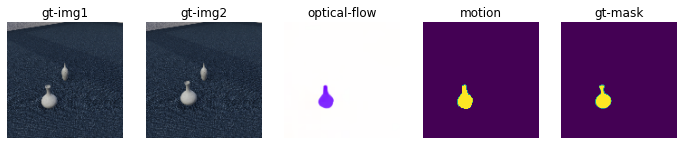

In [12]:
plt.rcParams["savefig.bbox"] = "tight"
num = 5
plt.figure("gt-imgs", figsize = (12,12))
plt.subplot(1,num,1)
plt.axis("off")
plt.title("gt-img1")
plt.imshow(img1[batch_index].permute(1,2,0))
plt.subplot(1,num,2)
plt.axis("off")
plt.title("gt-img2")
plt.imshow(img2[batch_index].permute(1,2,0))
plt.subplot(1,num,3)
plt.axis("off")
plt.title("optical-flow")
plt.imshow(flow_imgs[batch_index].permute(1,2,0))
plt.subplot(1,num,4)
plt.axis("off")
plt.title("motion")
motion_strength = torch.norm(predicted_flows[batch_index].permute(1,2,0).float() , dim = -1) 
plt.imshow( motion_strength > 0.5 )
plt.subplot(1,num,5)
plt.axis("off")
plt.title("gt-mask")
plt.imshow(masks[0])


In [13]:
import sys
from mvcl.utils import calculate_IoU_matrix, calculate_mIoU, expand_mask, to_onehot_mask

def preprocess(batch):
    transforms = T.Compose(
        [
            T.ConvertImageDtype(torch.float32),
            T.Normalize(mean=0.5, std=0.5),  # map [0, 1] into [-1, 1],
        ]
    )
    batch = transforms(batch)
    return batch

def train(model, dataset, batch_size = 2, epochs = 100):
    """
    Args:
        model: the symbolic grouping networks model that use language and motion cues to learn affinity
    Returns:
        the trained model is returned, it is also saved in the checkpoints
    """
    model.train()
    loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)
    optimizer = torch.optim.Adam(model.parameters(), lr = 2e-4)
    
    """pure motion trainig requires optical flow as input, if the optical flow map is not precomputed it is esitmated"""
    flow_predicter = raft_large(pretrained=True, progress=False).to(device)
    flow_predicter = flow_predicter.eval()

    for epoch in range(epochs):
        epoch_loss = 0.0
        num_samples = 0
        miou = []
        for sample in loader:
            img1 = sample["img1"]
            img2 = sample["img2"]
            gt_masks = sample["masks"]
            num_samples += img1.shape[0] # add the batch number ot the total number of the samples iterated

            """predict the optical flow and motion direction as cues"""
            list_of_flows = flow_predicter(
                preprocess(img1).to(device),
                preprocess(img2).to(device))
            predicted_flows = list_of_flows[-1]
            motion_strength = torch.norm(predicted_flows.permute(0,2,3,1).float() , dim = -1) 

            """collect the affinity cues using various sources (motion, direction, albedo etc.)"""
            cues = {
            "movable": (motion_strength > 0.5).float()
            }
            
            outputs = model(img1, cues, verbose = False)
            predict_masks = outputs["masks"]["movable"]
            losses = outputs["loss"]
            
            """collect losses from the model output for object affinity learning."""
            working_loss = 0.0
            for loss_name in losses:
                working_loss += losses[loss_name]
            sample_miou = calculate_mIoU(gt_masks.to("cpu"), predict_masks.to("cpu"))
            miou.append(sample_miou.cpu().detach().numpy())
            
            """start the optimization of the overall loss of object adapter and affinity cues."""
            optimizer.zero_grad()
            working_loss.backward()
            optimizer.step()
            epoch_loss += working_loss.cpu().detach()
            sys.stdout.write(f"\repoch:{epoch+1} [{num_samples}/{len(dataset)}] loss:{working_loss.cpu().detach().numpy()} mIoU:{sum(miou)/len(miou)}")
        torch.save(model.state_dict(), "checkpoints/states.pth")
    sys.stdout.write(f"\nepoch {epoch+1} completed with loss {epoch_loss}")
    

In [63]:
sgnet = SymbolicGrouper(resolution = resolution, K = 7)
plagueworks_dataset = PlagueWorksDataset(dataset_dir = dataset_dir, resolution=resolution)
train(sgnet, plagueworks_dataset, epochs = 100, batch_size = 1)

epoch:100 [7/7] loss:0.059166550636291504 mIoU:0.6463245834623065
epoch 100 completed with loss 0.4673083424568176

In [14]:

sgnet = SymbolicGrouper(resolution = resolution, K = 7)
sgnet.load_state_dict(torch.load("checkpoints/states.pth", map_location="cpu"))
#sgnet.num_long_range = 325
sgnet.eval()

cues = {
    "movable": (motion_strength > 0.5).float().unsqueeze(0)
}

outputs = sgnet(img1, cues, verbose = 1)

print(outputs["loss"]["movable"])
sample_masks = outputs["masks"]["movable"]
sample_inds = outputs["indices"]
sample_aff = outputs["affinity"]["movable"]
#visualize_affinities(sample_inds.cpu(), sample_aff.cpu(), img1.cpu(), 6000)

torch.Size([1, 16384, 128])
graph_in torch.Size([16384, 128]) torch.Size([2, 950272]) torch.Size([16384])
torch.Size([950272]) tensor(5.7573, grad_fn=<MaxBackward1>) tensor(-4.8280, grad_fn=<MinBackward1>)


/Users/melkor/miniforge3/envs/Melkor/lib/python3.9/site-packages/torch_sparse/storage.py:14: UserWarning: `layout` argument unset, using default layout "coo". This may lead to unexpected behaviour.
  warnings.warn('`layout` argument unset, using default layout '


tensor(0.0529, grad_fn=<AddBackward0>)


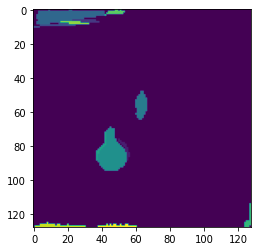

In [18]:
cc_masks = to_cc_masks(sample_masks[0], 22)

W, H, M = cc_masks.shape
vis_mask = np.zeros([W, H])
for i in range(cc_masks.shape[2]):
    vis_mask[cc_masks[:,:,i]==1] = i+1
plt.imshow(vis_mask)

#torch.save(sgnet.state_dict(), "outputs/refractor.pth")

In [19]:
print(masks[0].shape, torch.tensor(to_cc_masks(sample_masks[0])).shape)
calculate_mIoU(masks[0].unsqueeze(0), torch.tensor(to_cc_masks(sample_masks[0])).unsqueeze(0))

torch.Size([128, 128]) torch.Size([128, 128, 23])


tensor(0.9158)

In [20]:
class QuadraticCurve(nn.Module):
    def __init__(self, arity = 1):
        super().__init__()
        self.arity = arity
        self.px = nn.Parameter(torch.randn([arity]))
        self.py = nn.Parameter(torch.randn([arity]))
        self.pa = nn.Parameter(torch.randn([arity]))
        self.pr = nn.Parameter(torch.randn([arity]))

    def forward(self, grid):
        """
        Args:
            grid:
        Returns:
            the grid colored with the quadratic curve
        """
        parts = []
        mx,my = grid[:,:,0],grid[:,:,1]
        for i in range(self.arity):
            px,py,pa,pr = self.px[i], self.py[i], self.pa[i], self.pr[i]
        
            quadratic_part = \
            F.softplus(pa) * (my * (torch.cos(pr)) - mx * (torch.sin(pr)) - px) ** 2 - \
             (mx * (torch.cos(pr)) + my * (torch.sin(pr)) - py)
            
            parts.append(1 - quadratic_part[..., None])
        parts = torch.cat(parts, dim = -1)
 
        return torch.sigmoid(torch.min(parts, dim = -1).values)
    
class QuadraticTexture(nn.Module):
    def __init__(self, arity = 1):
        super().__init__()
        self.arity = arity
        self.ch = nn.Parameter(torch.randn([arity]))
        self.cw = nn.Parameter(torch.randn([arity]))
        self.a = nn.Parameter(torch.randn([arity]))
        self.ah = nn.Parameter(torch.randn([arity]))
        self.aw = nn.Parameter(torch.randn([arity]))
        self.ahh = nn.Parameter(torch.randn([arity]))
        self.aww = nn.Parameter(torch.randn([arity]))
        self.ahw = nn.Parameter(torch.randn([arity]))

    def forward(self, grid):
        mx,my = grid[:,:,0],grid[:,:,1]
        
        channels = []
        for i in range(self.arity):
            ch, cw = self.ch, self.cw
            var = self.a[i] + \
            self.ah[i]*(mx - ch) + self.aw[i]*(my - cw) +\
            self.ahh[i]*(mx - ch)**2 + self.aww[i]*(my - cw)**2 + \
                self.ahw[i] * (mx - ch) * (my - cw)
            channels.append(var[..., None])
        channels = torch.cat(channels, dim = -1)
        return channels.sigmoid()

epoch:50000 BCE:-0.29384672641754155453

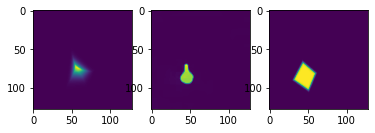

In [32]:
qsr = QuadraticCurve(8)
#qsr = QuadraticTexture(1)
grid = (sgnet.spatial_coords.reshape([128,128,2]) -0.5) * 12.

original_map = qsr(grid)
predict_map = qsr(grid).squeeze(-1)

optimizer = torch.optim.Adam(qsr.parameters(), lr = 2e-4)
for epoch in range(50000):
    predict_map = qsr(grid).squeeze(-1)
    gt_map = motion_strength.cpu().detach().int().float()
    loss = torch.nn.functional.mse_loss(predict_map, gt_map)
    loss = torch.nn.functional.binary_cross_entropy(predict_map, gt_map)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    sys.stdout.write(f"\repoch:{epoch+1} BCE:{loss.cpu().detach().numpy()}")

plt.figure("Quadratic Shape Render")
plt.subplot(131)
plt.imshow(original_map.cpu().detach())
plt.subplot(132)
plt.imshow(motion_strength.cpu().detach())
plt.subplot(133)
plt.imshow(predict_map.cpu().detach())
